In [ ]:
! pip install -r requirements.txt

In [253]:
from config import TRAIN_PATH, VALID_PATH

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec

import json
import os

from pprint import pprint

In [254]:
def flatten(something):
    if isinstance(something, (list, tuple, set, range)):
        for sub in something:
            yield from flatten(sub)
    else:
        yield something

def get_unique_colors(data, skip_zero=True):
    colors, counts = np.unique(list(flatten(data)), return_counts=True)

    no_colors = sum(counts)
    color_counts = {color: 0 for color in range(0,10)}
    for i, color in enumerate(colors):
        if skip_zero and i == 0:
            continue
        color_counts[color] = counts[i] 

    return (no_colors, color_counts)

def get_dimensions(task):
    x = len(task)
    y = len(task[0]) if x > 0 else 0
    return (x, y)

In [283]:

def plot_examples(data_path, idx_list, *, save = None):
    training_tasks = sorted(os.listdir(data_path))
    for i in idx_list:
        task_file = str(data_path / training_tasks[i])
        with open(task_file, 'r') as f:
            task = json.load(f)
        cmap = colors.ListedColormap(
            ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
            '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
        norm = colors.Normalize(vmin=0, vmax=9)
        fig, axs = plt.subplots(1, 4, figsize=(15,15))
        axs[0].imshow(task['train'][0]['input'], cmap=cmap, norm=norm)
        axs[0].axis('off')
        axs[0].set_title('Train Input')
        axs[1].imshow(task['train'][0]['output'], cmap=cmap, norm=norm)
        axs[1].axis('off')
        axs[1].set_title('Train Output')
        axs[2].imshow(task['test'][0]['input'], cmap=cmap, norm=norm)
        axs[2].axis('off')
        axs[2].set_title('Test Input')
        axs[3].imshow(task['test'][0]['output'], cmap=cmap, norm=norm)
        axs[3].axis('off')
        axs[3].set_title('Test Output')
        plt.tight_layout()
        if save:
            plt.savefig( f"_{i}.".join(save.rsplit('.')))
        else:
            plt.show()

def plot_unique_colors(data_path, *, idx_list = None, skip_zero = True, save = None):
    GRAPH_TYPES = {
        'train-in': 'Train Inputs',
        'train-out': 'Train Outputs',
        'test-in': 'Test Inputs',
        'test-out': 'Test Outputs',
        'overall': 'Overall',
    }
    color_counts = {}
    no_colors = {}
    for t in GRAPH_TYPES:
        color_counts[t] = 10 * [0] # {color: 0 for color in range(0,10)}
        no_colors[t] = 0

    training_tasks = sorted(os.listdir(data_path))
    if not idx_list:
        idx_list = list(range(len(training_tasks)))

    for i in idx_list:
        task_file = str(data_path / training_tasks[i])
        with open(task_file, 'r') as f:
            task = json.load(f)

            no_color_tri, color_count_tri = get_unique_colors(
                [ v['input'] for v in task['train'] ],
                skip_zero=skip_zero
            )
            no_color_tro, color_count_tro = get_unique_colors(
                [ v['output'] for v in task['train'] ],
                skip_zero=skip_zero
            )
            no_color_tei, color_count_tei = get_unique_colors(
                [ v['input'] for v in task['test'] ],
                skip_zero=skip_zero
            )
            no_color_teo, color_count_teo = get_unique_colors(
                [ v['output'] for v in task['test'] ],
                skip_zero=skip_zero
            )

            no_colors['train-in'] += no_color_tri
            no_colors['train-out'] += no_color_tro
            no_colors['test-in'] += no_color_tei
            no_colors['test-out'] += no_color_teo

            for k, v in color_count_tri.items(): 
                color_counts['train-in'][k] += v
                color_counts['overall'][k] += v
            for k, v in color_count_tro.items(): 
                color_counts['train-out'][k] += v
                color_counts['overall'][k] += v
            for k, v in color_count_tei.items(): 
                color_counts['test-in'][k] += v
                color_counts['overall'][k] += v
            for k, v in color_count_teo.items(): 
                color_counts['test-out'][k] += v
                color_counts['overall'][k] += v

    # Show a histogram of our used colors
    colorvs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
    fig, axs = plt.subplots(1, len(GRAPH_TYPES))
    for i, (key, title) in enumerate(GRAPH_TYPES.items()):
        _,_,patches = axs[i].hist(list(range(10)), weights=color_counts[key])
        for idx, p in enumerate(patches): p.set_facecolor(colorvs[idx])
        axs[i].set_title(title)
        axs[i].set_xlabel('Color')
        # axs[i].set_xticks(list(range(10)))
        if i == 0: axs[i].set_ylabel('Count')


    plt.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

def plot_dimensions(data_path, *, idx_list = None, save = None):
    GRAPH_TYPES = {
        'train-in': 'Train Inputs',
        'train-out': 'Train Outputs',
        'test-in': 'Test Inputs',
        'test-out': 'Test Outputs',
        'overall': 'Overall',
    }
    dimensions = {}
    for t in GRAPH_TYPES:
        dimensions[t] = [] 

    training_tasks = sorted(os.listdir(data_path))
    if not idx_list:
        idx_list = list(range(len(training_tasks)))

    for i in idx_list:
        task_file = str(data_path / training_tasks[i])
        with open(task_file, 'r') as f:
            task = json.load(f)

            dimensions['train-in'] += [ get_dimensions(v['input']) for v in task['train'] ]
            dimensions['train-out'] += [ get_dimensions(v['output']) for v in task['train'] ]
            dimensions['test-in'] += [ get_dimensions(v['input']) for v in task['test'] ]
            dimensions['test-out'] += [ get_dimensions(v['output']) for v in task['test'] ]

    dimensions['overall'] = dimensions['train-in'] + dimensions['train-out'] + dimensions['test-in'] + dimensions['test-out'] 

    # Show a histogram of our dimensions
    colorvs = ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
    fig = plt.figure(constrained_layout=True, figsize=(5, 8))
    gs = GridSpec(3, 2, figure=fig)

    for (key, title) in GRAPH_TYPES.items():
        if key == "overall": ax = fig.add_subplot(gs[2, :])
        if key == "train-in": ax = fig.add_subplot(gs[0, 0])
        if key == "train-out": ax = fig.add_subplot(gs[0, 1])
        if key == "test-in": ax = fig.add_subplot(gs[1, 0])
        if key == "test-out": ax = fig.add_subplot(gs[1, 1])

        xs = [ x for (x, y) in dimensions[key]]
        ys = [ y for (x, y) in dimensions[key]]
        ax.hist2d(xs, ys)
        ax.set_title(title)
        ax.set_xlabel('Dimension X')
        ax.set_ylabel('Dimension Y')

    if save:
        plt.savefig(save)
    else:
        plt.show()



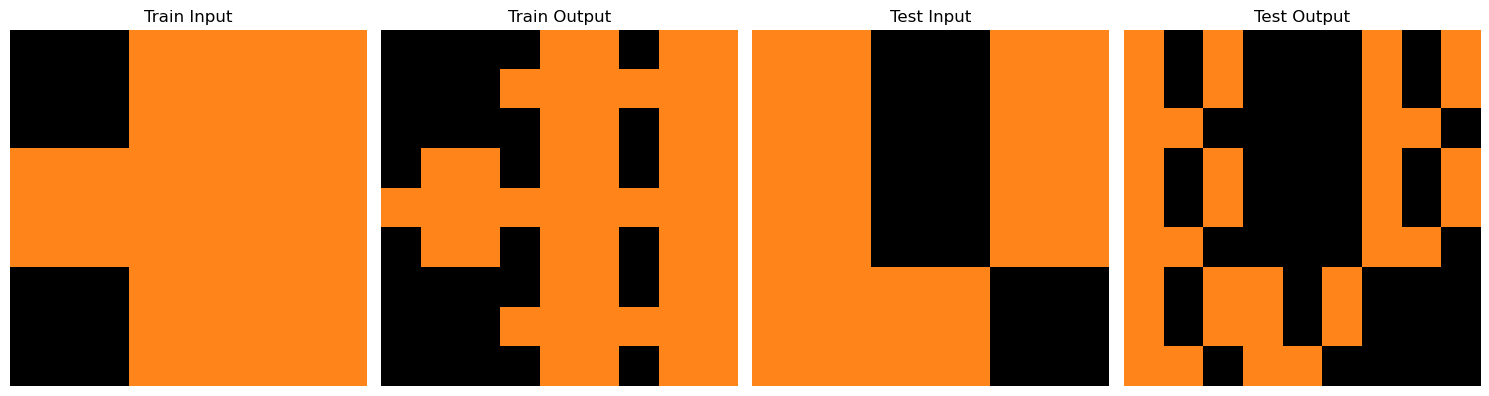

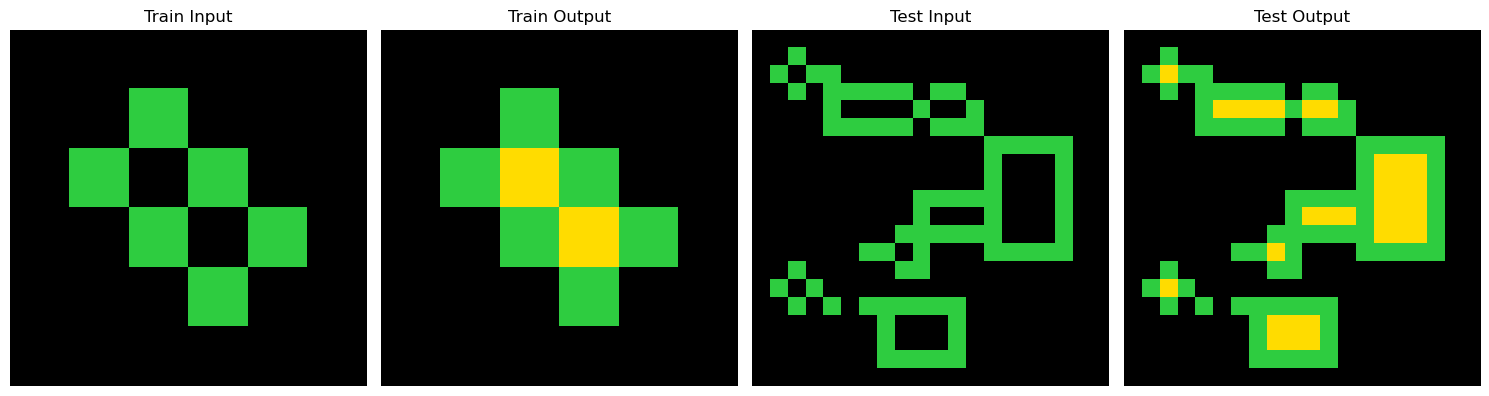

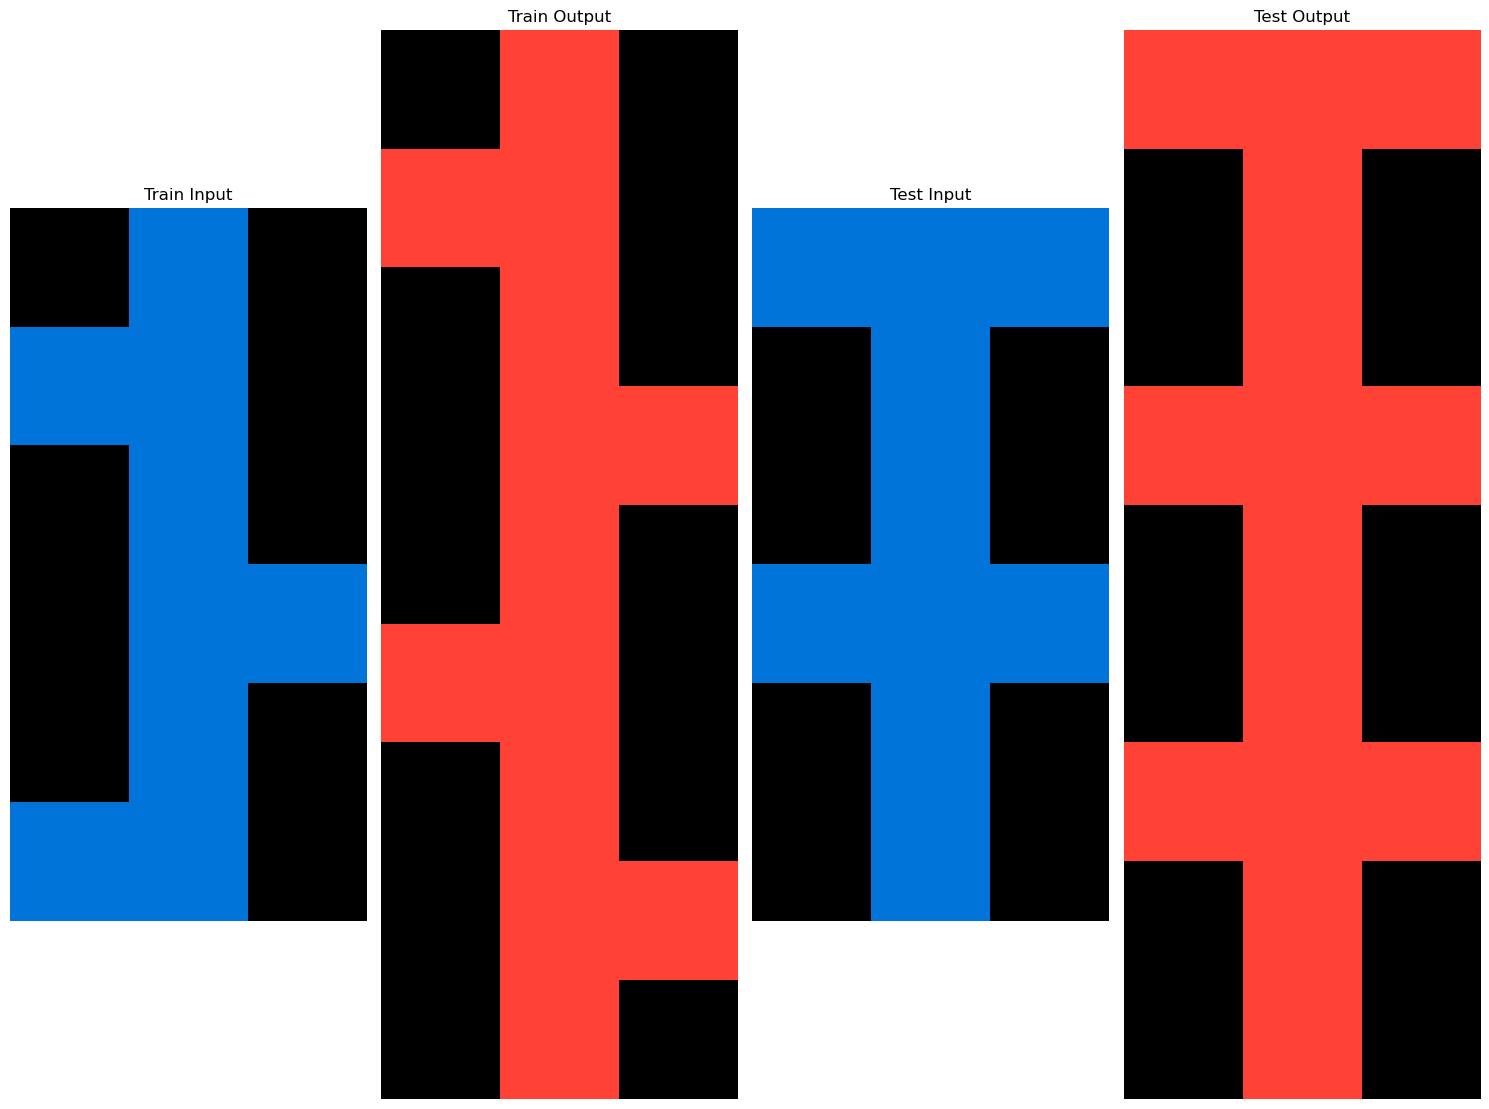

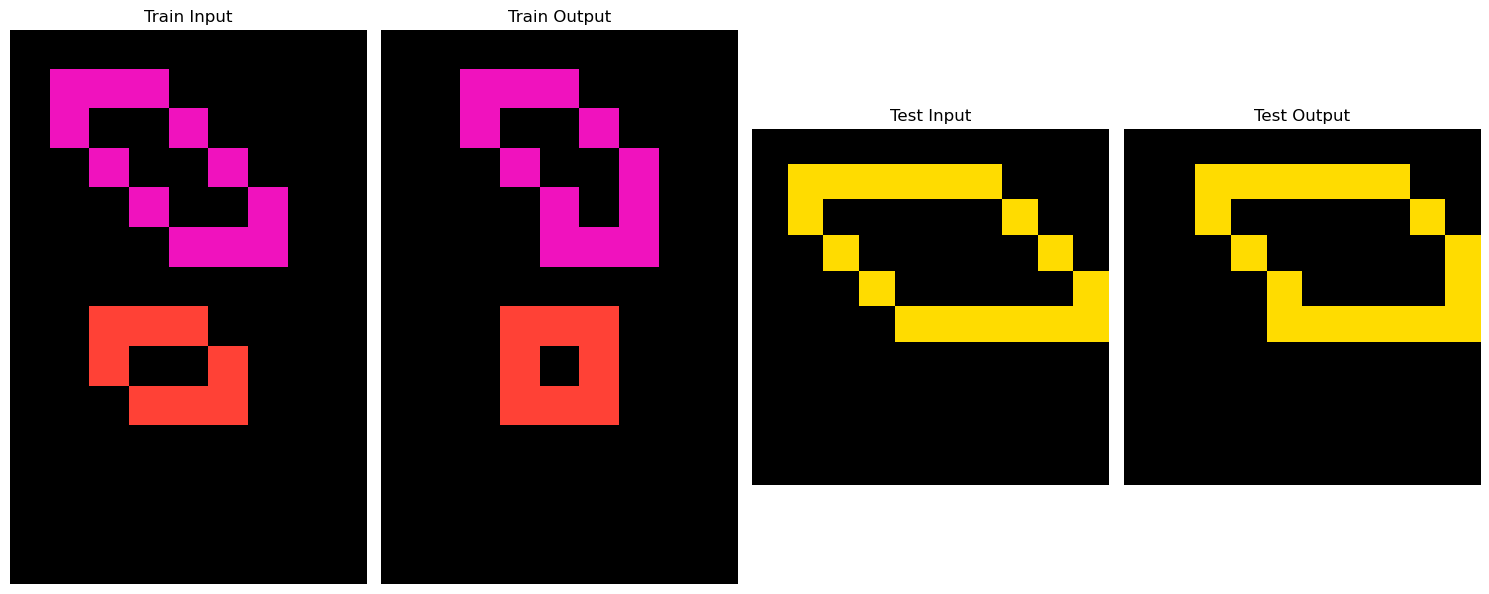

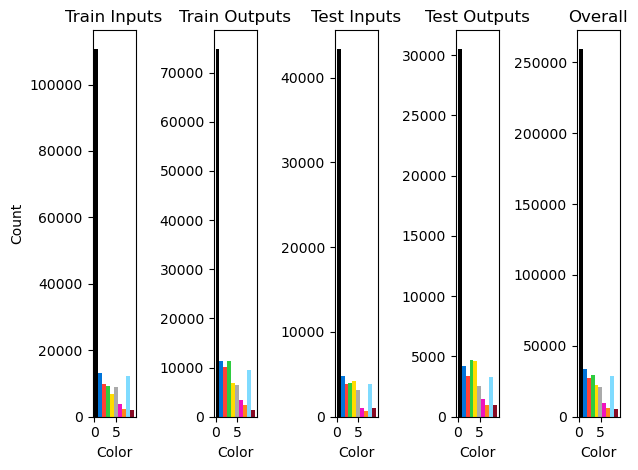

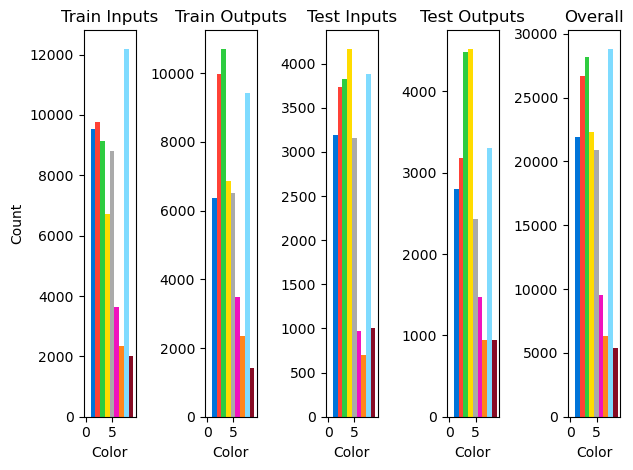

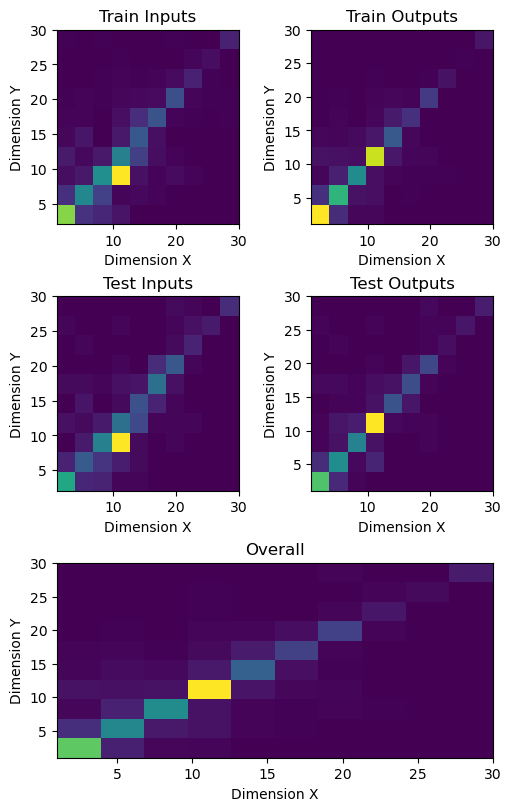

In [284]:
# plot_examples(TRAIN_PATH, [0])
# plot_unique_colors(TRAIN_PATH, skip_zero=False)
# plot_unique_colors(TRAIN_PATH, skip_zero=True)
# plot_dimensions(TRAIN_PATH)


plot_examples(TRAIN_PATH, [0, 1, 2, 3], save="images/data_exploration/example.svg")
plot_unique_colors(TRAIN_PATH, skip_zero=False, save="images/data_exploration/colors.svg")
plot_unique_colors(TRAIN_PATH, skip_zero=True, save="images/data_exploration/colors_wzero.svg")
plot_dimensions(TRAIN_PATH, save="images/data_exploration/dimensions.svg")
